In [140]:
# Salvar como install_from_pyproject.py e executar: python install_from_pyproject.py
import tomllib, subprocess, sys
with open("pyproject.toml","rb") as f:
    data = tomllib.load(f)
deps = data.get("project", {}).get("dependencies", [])
if not deps:
    print("Nenhuma dependency encontrada em pyproject.toml", file=sys.stderr); sys.exit(1)
for dep in deps:
    print("uv add", dep)
    subprocess.run(["uv", "add", dep], check=True)

uv add folium>=0.20.0
uv add geopy>=2.4.1
uv add matplotlib>=3.10.7
uv add numpy>=2.3.5
uv add pandas>=2.3.3
uv add seaborn>=0.13.2
uv add streamlit<=1.51.0
uv add plotly<=6.5.0


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Para o mapa
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# Configurações gerais
plt.style.use('seaborn-v0_8')
sns.set_palette("hls", 8)
%matplotlib inline

In [142]:
df = pd.read_csv('./data/winemag-data-130k-v2.csv')  # altera o nome se for diferente
df.head(200)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,Italy,"This is a mature, jammy wine with thick layers...",Riserva,87,35.0,Tuscany,Vino Nobile di Montepulciano,NaN,NaN,NaN,Carpineto 2003 Riserva (Vino Nobile di Montep...,Prugnolo Gentile,Carpineto
196,196,Italy,Pancole is a pretty expression of Tuscany's po...,Pancole,87,18.0,Tuscany,Vernaccia di San Gimignano,NaN,NaN,NaN,Cesani 2007 Pancole (Vernaccia di San Gimignano),Vernaccia,Cesani
197,197,South Africa,"This is a concentrated, fairly full and lush C...",21 Gables,90,23.0,Western Cape,NaN,NaN,Lauren Buzzeo,@laurbuzz,Spier 2014 21 Gables Chenin Blanc (Western Cape),Chenin Blanc,Spier
198,198,US,"This is a soft, well-crafted wine from the eas...",Four Soil Mélange,90,60.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Sequum 2013 Four Soil Mélange Cabernet Sauvign...,Cabernet Sauvignon,Sequum


In [143]:
# Países da União Europeia (27 países em 2025)
eu_countries = ['Portugal', 'France', 'Italy', 'Spain', 'Germany', 'Austria', 
                'Greece', 'Hungary', 'Romania', 'Bulgaria', 'Croatia', 'Slovenia',
                'Slovakia', 'Czech Republic', 'Poland', 'Cyprus', 'Malta',
                'Belgium', 'Netherlands', 'Luxembourg', 'Ireland', 'Denmark',
                'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania']

# Filtrar apenas vinhos da UE
df_eu = df[df['country'].isin(eu_countries)].copy()

print(f"Total de reviews globais: {len(df)}")
print(f"Reviews de vinhos da UE: {len(df_eu)} ({len(df_eu)/len(df)*100:.1f}%)")

Total de reviews globais: 129971
Reviews de vinhos da UE: 60542 (46.6%)


In [144]:
# Remover linhas sem país ou sem pontos
df_eu = df_eu.dropna(subset=['country', 'points'])

# Preencher preço missing com mediana por país (melhor que remover)
df_eu['price'] = df_eu.groupby('country')['price'].transform(lambda x: x.fillna(x.median()))
df_eu['price'].fillna(df_eu['price'].median(), inplace=True)

# Criar coluna qualidade/preço
df_eu['points_per_euro'] = df_eu['points'] / df_eu['price']

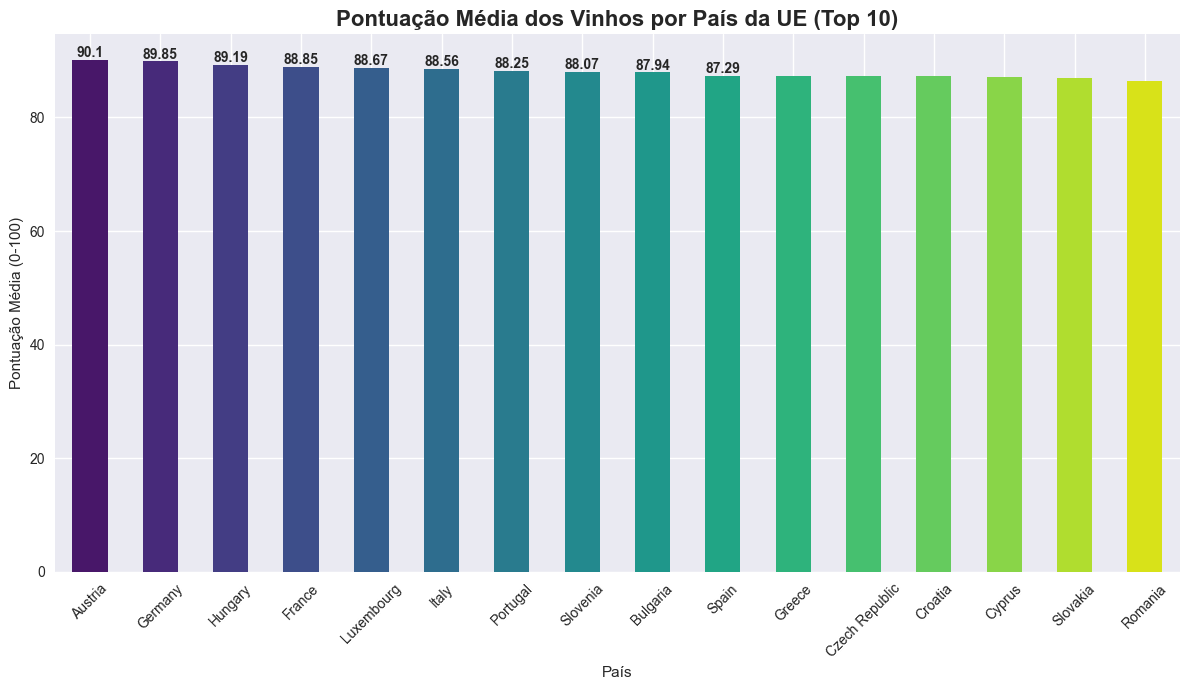

country
Austria       90.10
Germany       89.85
Hungary       89.19
France        88.85
Luxembourg    88.67
Italy         88.56
Portugal      88.25
Slovenia      88.07
Bulgaria      87.94
Spain         87.29
Name: points, dtype: float64

In [145]:
top_countries = df_eu.groupby('country')['points'].mean().sort_values(ascending=False).round(2)

plt.figure(figsize=(12,7))
ax = top_countries.plot(kind='bar', color=sns.color_palette("viridis", len(top_countries)))
plt.title('Pontuação Média dos Vinhos por País da UE (Top 10)', fontsize=16, fontweight='bold')
plt.ylabel('Pontuação Média (0-100)')
plt.xlabel('País')
plt.xticks(rotation=45)
for i, v in enumerate(top_countries.head(10)):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

top_countries.head(10)

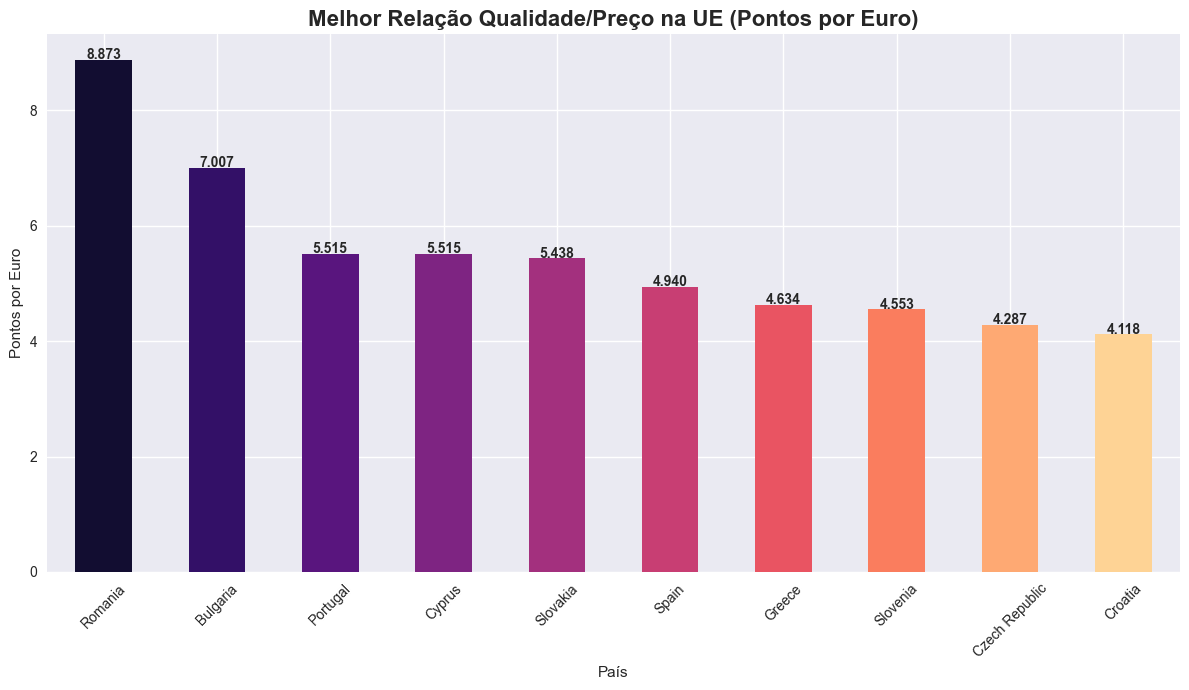

In [146]:
quality_price = df_eu.groupby('country')['points_per_euro'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,7))
ax = quality_price.head(10).plot(kind='bar', color=sns.color_palette("magma", 10))
plt.title('Melhor Relação Qualidade/Preço na UE (Pontos por Euro)', fontsize=16, fontweight='bold')
plt.ylabel('Pontos por Euro')
plt.xlabel('País')
plt.xticks(rotation=45)
for i, v in enumerate(quality_price.head(10)):
    ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

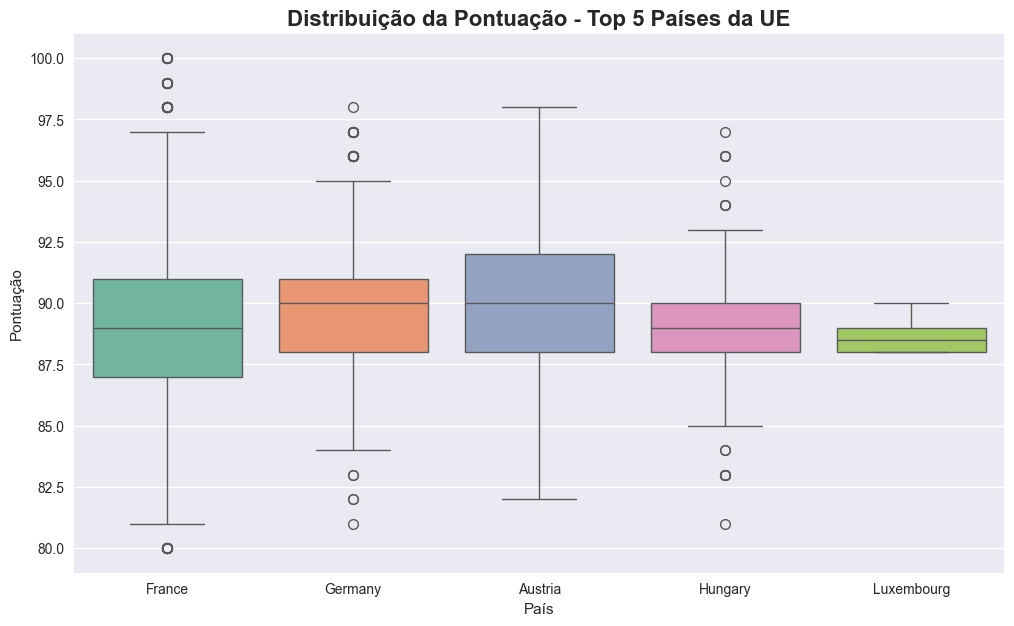

In [147]:
top5_countries = top_countries.head(5).index.tolist()

plt.figure(figsize=(12,7))
sns.boxplot(data=df_eu[df_eu['country'].isin(top5_countries)], x='country', y='points', palette="Set2")
plt.title('Distribuição da Pontuação - Top 5 Países da UE', fontsize=16, fontweight='bold')
plt.ylabel('Pontuação')
plt.xlabel('País')
plt.show()

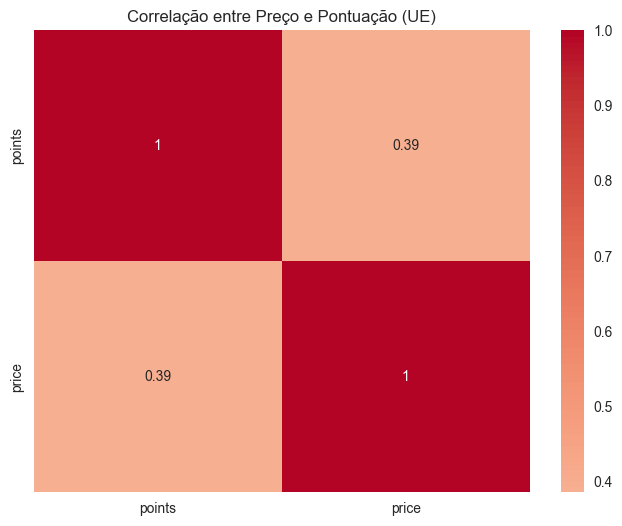

In [148]:
plt.figure(figsize=(8,6))
sns.heatmap(df_eu[['points', 'price']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre Preço e Pontuação (UE)')
plt.show()

In [149]:
# Centro da Europa
europe_map = folium.Map(location=[54, 15], zoom_start=4, tiles='CartoDB positron')

# Média de pontos por país
country_points = df_eu.groupby('country')['points'].mean().round(1)

# Coordenadas aproximadas dos países (podes melhorar se quiseres)
coordinates = {
    'Portugal': [39.5, -8.2], 'Spain': [40.4, -3.7], 'France': [46.2, 2.2],
    'Italy': [42.5, 12.1], 'Germany': [51.1, 10.4], 'Austria': [47.5, 13.2],
    'Hungary': [47.1, 19.5], 'Romania': [45.9, 24.9], 'Greece': [39.0, 21.8],
    'Bulgaria': [42.7, 25.4], 'Croatia': [45.1, 15.2]
}

for country, coord in coordinates.items():
    if country in country_points.index:
        points = country_points[country]
        folium.CircleMarker(
            location=coord,
            radius=points/3,
            popup=f"<b>{country}</b><br>Pontuação média: {points}",
            color='crimson',
            fill=True,
            fill_color='crimson',
            fill_opacity=0.7
        ).add_to(europe_map)

europe_map.save('mapa_melhores_vinhos_UE.html')
europe_map

In [150]:
top10_vinhos = df_eu.nlargest(10, 'points')[['title', 'country', 'winery', 'points', 'price', 'variety']]
top10_vinhos.index = range(1,11)
top10_vinhos

,title,country,winery,points,price,variety
1,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Italy,Avignonesi,100,210.0,Prugnolo Gentile
2,Krug 2002 Brut (Champagne),France,Krug,100,259.0,Champagne Blend
3,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Italy,Tenuta dell'Ornellaia,100,460.0,Merlot
4,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portugal,Casa Ferreirinha,100,450.0,Portuguese Red
5,Biondi Santi 2010 Riserva (Brunello di Montal...,Italy,Biondi Santi,100,550.0,Sangiovese
6,Château Léoville Barton 2010 Saint-Julien,France,Château Léoville Barton,100,150.0,Bordeaux-style Red Blend
7,Louis Roederer 2008 Cristal Vintage Brut (Cha...,France,Louis Roederer,100,250.0,Champagne Blend
8,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,France,Salon,100,617.0,Chardonnay
9,Château Lafite Rothschild 2010 Pauillac,France,Château Lafite Rothschild,100,1500.0,Bordeaux-style Red Blend
10,Casanova di Neri 2007 Cerretalto (Brunello di...,Italy,Casanova di Neri,100,270.0,Sangiovese Grosso


In [151]:
# Para ver a app interativa, executa no terminal:
# streamlit run app.py

import os
if os.path.exists("app.py"):
    print("App Streamlit pronta! Abre o terminal e escreve:")
    print("streamlit run app.py")
else:
    print("Cria o ficheiro app.py com o código Streamlit para teres a versão interativa!")

App Streamlit pronta! Abre o terminal e escreve:
streamlit run app.py
